<span style="font-family:Lucida Bright;">

<hr style="border:2px solid black"> </hr>

<p style="margin-bottom:1cm"></p>

<center>
<font size="7"><b>Social Data Analysis and Visualization</b></font>
<p style="margin-bottom:1cm"></p>
<font size="6.8"><b>Final Project</b></font>   
<p style="margin-bottom:0.8cm"></p>
<font size="3"><b>Wojciech Mazurkiewicz, DTU, 14 May 2021</b></font>
<br>
<font size="3"><b></b></font>

</center>

<p style="margin-bottom:0.7cm"></p>

<hr style="border:2px solid black"> </hr>

<hr style="border:2px solid black"> </hr>

<span style="font-family:Lucida Bright;">

# Initialization

## How to read this notebook

In this notebook, the questions are either specified in the section title, or marked with

> __bold quote__

The answers are marked with <span style="font-family:Lucida Bright;">*Lucida Bright italics*</span>.

Please note that the pre-rendered outputs will first display properly when the notebook is __trusted__.
    
</span>

## Imports

In [1]:
%matplotlib inline

import bokeh.plotting as bplt
import calendar
import datetime
import folium
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import scipy.stats
import seaborn as sns
import urllib.request

from bokeh.io import output_file
from bokeh.io import output_notebook
from bokeh.io import show
from bokeh.models import Legend
from bokeh.models.ranges import FactorRange
from bokeh.models.sources import ColumnDataSource
from folium.map import FeatureGroup
from folium.plugins import HeatMap, HeatMapWithTime
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
from IPython.display import Markdown
from IPython.display import YouTubeVideo
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.image import NonUniformImage
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
from scipy import stats
from sklearn.datasets import fetch_20newsgroups
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm


##  Configuration

In [2]:
# Show bokeh figures in the notebook.
output_notebook()

# Below decide which output is shown below the cells.
InteractiveShell.ast_node_interactivity = "none"

# Define the format in which the numbers will be shown in
# the pandas dataframes.
pd.options.display.float_format = '{:,.2f}'.format

# Decide how to handle the "SettingWithCopyWarning" warning
pd.options.mode.chained_assignment = None  # default='warn'

# Set the maximum number of rows to show when displaying
# a Pandas dataframe.
pd.options.display.max_rows = 150

Loading BokehJS ...

## Function definitions

### Plotting functions

In [3]:
# A function that applies default formatting to an axes.
def format_axes(axes: plt.Axes,
                keep_box=False):
    if not keep_box:
        axes.spines['top'].set_color('white')
        axes.spines['right'].set_color('white')

    axes.set_facecolor("white")


# A function that applies default formatting to annotation
# of an axes.
def format_axes_annotation(axes: plt.Axes):
    axes.xaxis.label.set_fontsize(14)
    axes.yaxis.label.set_fontsize(14)
    axes.title.set_fontsize(16)


# A function for creating common x-label for the figure.
def figure_x_label(figure: plt.Figure,
                   label: str,
                   y_position=0.04,
                   font_size=16):
    figure.text(0.5, y_position, label,
                ha='center',
                fontdict={'size': font_size})


# A function for creating common y-label for the figure.
def figure_y_label(figure: plt.Figure,
                   label: str,
                   x_position=0.04,
                   font_size=16):
    figure.text(x_position, 0.5, label,
                va='center',
                rotation='vertical',
                fontdict={'size': font_size})


# A function that draws a horizontal line across the entire axes.
def draw_threshold(value: float,
                   axes: plt.Axes,
                   linewidth=1,
                   linestyle='-',
                   color=None,
                   title=None):
    
    # Get axes limits and ranges.
    x_min, x_max = axes.get_xlim()
    x_range = x_max - x_min
    y_min, y_max = axes.get_ylim()
    y_range = y_max - y_min
    
    # Plot the threshold line.
    axes.plot([x_min, x_max], [value, value],
              linewidth=1,
              linestyle='-',
              color=color)
    
    # Write a title above the threshold line
    if title is not None:
        axes.text(x_min + 0.01 * x_range,
                  value + 0.02 * y_range,
                  title)

###  Dataframe functions

In [4]:
# A function for balancing a dataframe so that the number of rows
# containing each value present in the designated column will be the same.
def balance_dataframe(df: pd.DataFrame, column_name):
    # Get the number of crimes for the least frequent crime.
    lowest_frequency = df['Category'].value_counts().min()

    # Create an empty dataframe for storing the balanced data
    df_balanced = pd.DataFrame()

    # For each value in column, randomly choose the number of samples
    # that corresponds to the least frequent value in the column.
    for value in df[column_name].unique():
        df_balanced = df_balanced.append(
            df
            .loc[df[column_name] == value]
            .sample(lowest_frequency)
        )

    return df_balanced


# A function that evaluates a dictionary of models on data from
# a pandas dataframe.
def evaluate_models(models: dict,
                    df: pd.DataFrame,
                    predictor_labels: list,
                    target_label: str,
                    test_size=0.33):

    # Get the dataset.
    X = df.loc[:, predictor_labels].values
    y = df.loc[:, target_label].values

    # Split the dataset into a test and training set.
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=32)

    # Fit the models to the data.
    for model_name, model in models.items():

        # Print the name of the model.
        printmd(f'*__{model_name}:__*')

        # Train the model on the training set.
        model.fit(X_train, y_train)

        # Get the predictions on the test set.
        predictions = model.predict(X_test)

        # Print the classification report.
        print(classification_report(y_test, predictions,
                                    zero_division=0,
                                    digits=4))


# Define a function that loads a dataframe from
# kk.statistikbank.dk
def load_cph_df(path_csv):
    return pd.read_csv(path_csv,
                       sep='\t',
                       skiprows=0,
                       encoding='windows-1252')


# A function that loads a dataframe from multiple files.
def load_split_dataframe(paths_csv):

    # Load the first two dataframes.
    df_1 = load_cph_df(paths_csv[0])
    df_2 = load_cph_df(paths_csv[1])

    # Extract common columns.
    common_columns = list(set(df_1.columns)
                          & set(df_2.columns))

    # Load the whole dataframe.
    for idx, path_csv in enumerate(paths_csv):
        # Merge the dataframes.
        if idx == 0:
            df = load_cph_df(path_csv)
        else:
            df = df.merge(load_cph_df(path_csv),
                          left_on=common_columns,
                          right_on=common_columns)

    # Return the merged dataframe.
    return df


# A function that cleans the data about copenhagen district
def clean_districts(df: pd.DataFrame):
    df = df.copy()

    # Define the dame of the column containing info about districts.
    district_column_name = 'district'

    # Extract the district names.
    districts = df[district_column_name]

    # Initialize the list for storing district types.
    district_types = list()

    # Define valid districts.
    valid_districts = ['Indre By', 'Østerbro', 'Nørrebro', 'Vesterbro/Kongens Enghave', 'Valby',
                       'Vanløse', 'Brønshøj-Husum', 'Bispebjerg', 'Amager Øst', 'Amager Vest']

    # Define valid districts.
    valid_polling_areas = ['1. Østerbro', '1. Øst', '1. Nord', '1. Syd', '1. Vest', '1. Nordvest',
                           '2. Sundbyvester', '2. Nord', '2. Syd', '2. Øst', '2. Vest', '3. Indre By',
                           '3. Nord', '3. Syd', '3. Øst',
                           '4. Sundbyøster', '4. Nord', '4. Syd', '4. Øst',
                           '5. Nørrebro', '5. Nord', '5. Nørrebrohallen',
                           '5. Syd', '5. Øst', '5. Vest', '5. Nordvest',
                           '6. Bispebjerg', '6. Vest', '6. Nord', '6. Øst', '6. Syd',
                           '7. Brønshøj', '7. Nord', '7. Syd', '7. Øst', '7. Vest',
                           '7. Nordvest', '7. Katrinedal', '7. Kirkebjerg', '7. Vanløse',
                           '8. Valby', '8. Nord', '8. Syd', '8. Vest', '8. Sydøst', '8. Midt',
                           '9. Vesterbro', '9. Nord', '9. Syd',
                           '9. Øst', '9. Vest', '9. Midt', '9. Sydhavn']

    # Assign type to each district.
    for district in districts:
        if (('District' in district) | (district in valid_districts)):
            district_types.append('District')

        elif (('Polling area' in district) | (district in valid_polling_areas)):
            district_types.append('Polling area')

        elif 'Copenhagen total' in district:
            district_types.append('Entire Copenhagen')

        else:
            district_types.append('Unknown')

    # Insert the column "district type" next to the district column.
    idx_district_column = df.columns.to_list().index(district_column_name)
    df.insert(idx_district_column + 1, 'district type', district_types)

    # Clean the names in the district - column.
    for token in ['District -', 'Polling area -']:
        df[district_column_name] = (
            df[district_column_name]
            .str.replace(token, '')
            .str.strip()
        )

    return df


# A function that cleans all the information about the time in the
# dataframes for Copenhagen.
def clean_years(df: pd.DataFrame,
                non_year_columns=None):

    if non_year_columns is not None:
        # If "non_year_columns" is an integer, regard the first n
        # columns represented by the integer as non-year columns
        if isinstance(non_year_columns, int):
            non_year_columns = df.columns[:non_year_columns]
    else:
        non_year_columns = [column for column in df.columns.to_list()
                            if column[0] not in ['1', '2']]

    # Create a row for each Year and Quarter.
    df = df.melt(
        id_vars=non_year_columns,
        var_name="Time",
        value_name="Value"
    )

    # If the time is represented by a year and a quarter,
    # create columns "Year" and "Quarter" from the column "Time".
    if 'Q' in df.loc[0, 'Time']:
        df[['Year', 'Quarter']] = (
            df
            .pop('Time').str.split('Q', 2, expand=True)
            .astype(int)
        )

    # If year is presented as "XXXX:YYYY", take the second value.
    elif ':' in df.loc[0, 'Time']:
        df['Year'] = (
            df
            .pop('Time')
            .str.split(':').str[-1]
            .astype(int)
        )

    # Otherwise, transfor the year into an integer
    else:
        df['Year'] = df.pop('Time').astype(int)

    return df


# A function that perfoms standard cleaning of a dataframe
# from kk.statistikbank.dk
def clean_cph_dataframe(df):
    # Clean district information.
    df = clean_districts(df)

    # Clean time information.
    df = clean_years(df)

    # Capitalize column names.
    df.columns = [column.capitalize() for column in df.columns]

    return df


# A function that displays all basic stats about the dataframe.
def show_stats(df):
    # Show data types.
    display(df.dtypes.to_frame('Data types'))

    # Show missing values.
    display(
        df.isna()
        .sum()
        .to_frame('Number of missing values')
    )

    # Describe values in columns.
    display(df.describe(include='all'))

### Other functions

In [5]:
# A function that will print a markdown text.
def printmd(string):
    display(Markdown(string))

## Paths

In [6]:
path_root = Path(
    r'C:\GDrive\DTU\Kurser\Social_Data_Analysis_and_Visualization_02806\final_project')
path_resources_root = path_root / 'resources'
path_data_root = path_resources_root / 'data'

path_data_citizenship_root = path_data_root / 'citizenship'
path_data_dwellings_root = path_data_root / 'dwellings'
path_data_geo_root = path_data_root / 'geo'
path_data_marital_status_root = path_data_root / 'marital_status'
path_data_without_district_info_root = path_data_root / 'without_district_information'

path_data_clean_root = path_data_root / 'clean'

<hr style="border:2px solid black"> </hr>

# Trash bins

## Load data

In [7]:
df_trash_bins_raw = pd.read_csv(path_data_geo_root / 'affaldskurve_puma.csv')

display(df_trash_bins_raw)

,FID,id,wkb_geometry,status,driftsplan_navn,arbejdssted_navn,arbejdssted_id,tekst_id,lokaludvalg,byrumstype,underordnet_byrumstype,stednavn,underordnet_stednavn,kgb_kategori,geoobjekttypeid,kommentar,har_sensor,puma_geoobjektid
0,affaldskurve_puma.1,1,MULTIPOINT ((12.565692814694078 55.67932485271...,IDrift,Ørstedsparken,Ørstedsparken,144.00,Ørste_Ørste_144,Indre By,Parker,Klassisk park,Ørstedsparken,NaN,12.2.3 Richard Müller T5,a591f7eb-3cae-4aa3-bedf-a907000222ee,NaN,False,c03654e3-60e6-4408-bf2a-99eef82c91a9
1,affaldskurve_puma.2,2,MULTIPOINT ((12.56586038890235 55.679331097100...,IDrift,Ørstedsparken,Ørstedsparken,144.00,Ørste_Ørste_144,Indre By,Parker,Klassisk park,Ørstedsparken,NaN,12.2.3 Richard Müller T5,a591f7eb-3cae-4aa3-bedf-a907000222ee,NaN,False,10f099de-b107-45b6-8e94-17506cb7254f
2,affaldskurve_puma.3,3,MULTIPOINT ((12.566933919761878 55.68263944689...,IDrift,Ørstedsparken,Ørstedsparken,144.00,Ørste_Ørste_144,Indre By,Parker,Klassisk park,Ørstedsparken,NaN,12.2.2 Københavnerkurv,5ec05775-cc06-4dd6-8208-0a6148437eeb,NaN,False,ef13707a-7fe3-420e-855f-f43be1afb796
3,affaldskurve_puma.4,4,MULTIPOINT ((12.566245988511534 55.68270722067...,IDrift,Ørstedsparken,Ørstedsparken,144.00,Ørste_Ørste_144,Indre By,Parker,Klassisk park,Ørstedsparken,NaN,12.2.2 Københavnerkurv,5ec05775-cc06-4dd6-8208-0a6148437eeb,NaN,False,f74b90a1-8942-451c-a474-6400f2bd15cb
4,affaldskurve_puma.5,5,MULTIPOINT ((12.566669489138766 55.68256451356...,IDrift,Ørstedsparken,Ørstedsparken,144.00,Ørste_Ørste_144,Indre By,Parker,Lege- og aktivitetsområde,Ørstedsparken,NaN,12.2.2 Københavnerkurv,5ec05775-cc06-4dd6-8208-0a6148437eeb,NaN,False,ed4afaac-6fc1-403c-b052-9f205134486a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5241,affaldskurve_puma.7323,7323,MULTIPOINT ((12.612868979515607 55.68517836069...,IDrift,Bydækkende drift,NaN,NaN,NaN,Christianshavn,Gader og pladser,Øvrig gade,Gade i Indre By,NaN,12.2.3 Richard Müller T5,a591f7eb-3cae-4aa3-bedf-a907000222ee,NaN,False,23ca2957-573e-4eaf-ae8b-8c33695da5c5
5242,affaldskurve_puma.7325,7325,MULTIPOINT ((12.560076688652794 55.71294009667...,IDrift,Bydækkende drift,NaN,NaN,NaN,Østerbro,Gader og pladser,Øvrig gade,Kvarteret ved Skt. Kjelds Plads,NaN,12.2.2 Københavnerkurv,5ec05775-cc06-4dd6-8208-0a6148437eeb,NaN,True,56ccc289-2ab7-436d-914b-54e0a10c9528
5243,affaldskurve_puma.7326,7326,MULTIPOINT ((12.603868260188998 55.66482177747...,IDrift,Bydækkende drift,NaN,NaN,NaN,Amager Øst,Gader og pladser,Gade med grønt,Kvarteret ved Amagerbro Torv,NaN,12.2.2 Københavnerkurv,5ec05775-cc06-4dd6-8208-0a6148437eeb,NaN,False,9ed1a77e-b47e-455f-b0c4-a0cdb41be9b5
5244,affaldskurve_puma.7327,7327,MULTIPOINT ((12.587134919160713 55.67407987871...,IDrift,Bydækkende drift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.2.8 Pizzakurv,8755aaa9-70d1-49d7-b3aa-415dcf01d0d2,NaN,True,a1934124-5378-4df1-a99c-1eec227cd795


## Clean data

In [8]:
# Get the latitude and longitude of each bin.
df_trash_bins_clean = pd.DataFrame(
    df_trash_bins_raw
    .loc[:, 'wkb_geometry']
    .str.replace('MULTIPOINT', '', regex=False)
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
    .str.strip()
    .str.split()
    .to_list(),
    columns=['Longitude', 'Latitude']
).astype(float)

# Add other colums of interest.
df_trash_bins_clean = pd.concat(
    [df_trash_bins_clean,
     df_trash_bins_raw.loc[:, ['lokaludvalg',
                               'underordnet_byrumstype',
                               'kgb_kategori']]],
    axis='columns'
).rename(columns={'lokaludvalg': 'District',
                  'underordnet_byrumstype': 'Topology',
                  'kgb_kategori': 'Bin category'})

# Trim the bin categories.
df_trash_bins_clean['Bin category'] = \
    df_trash_bins_clean['Bin category'].str[7:].str.strip()


# Show the dataframe.
display(df_trash_bins_clean)

,Longitude,Latitude,District,Topology,Bin category
0,12.57,55.68,Indre By,Klassisk park,Richard Müller T5
1,12.57,55.68,Indre By,Klassisk park,Richard Müller T5
2,12.57,55.68,Indre By,Klassisk park,Københavnerkurv
3,12.57,55.68,Indre By,Klassisk park,Københavnerkurv
4,12.57,55.68,Indre By,Lege- og aktivitetsområde,Københavnerkurv
...,...,...,...,...,...
5241,12.61,55.69,Christianshavn,Øvrig gade,Richard Müller T5
5242,12.56,55.71,Østerbro,Øvrig gade,Københavnerkurv
5243,12.60,55.66,Amager Øst,Gade med grønt,Københavnerkurv
5244,12.59,55.67,NaN,NaN,Pizzakurv


## Statistics

### Data types

In [9]:
display(df_trash_bins_clean.dtypes.to_frame('Data types'))

,Data types
Longitude,float64
Latitude,float64
District,object
Topology,object
Bin category,object


### Value oveview

In [10]:
display(df_trash_bins_clean.describe(include='all'))

,Longitude,Latitude,District,Topology,Bin category
count,"5,246.00","5,246.00",4929,4627,5230
unique,NaN,NaN,12,12,21
top,NaN,NaN,Indre By,Klassisk park,Københavnerkurv
freq,NaN,NaN,1272,1243,2684
mean,12.56,55.68,NaN,NaN,NaN
std,0.04,0.02,NaN,NaN,NaN
min,12.45,55.61,NaN,NaN,NaN
25%,12.53,55.67,NaN,NaN,NaN
50%,12.56,55.68,NaN,NaN,NaN
75%,12.58,55.70,NaN,NaN,NaN


### Missing values

In [11]:
display(df_trash_bins_clean.isna().sum().to_frame('Number of missing values'))

,Number of missing values
Longitude,0
Latitude,0
District,317
Topology,619
Bin category,16


<hr style="border:2px solid black"> </hr>

# Marital status

## Source

www.statistikbanken.dk/FOLK1A

## Load data

In [12]:
# Load dataframe.
df_marital_status_raw = pd.read_csv(
    path_data_without_district_info_root / 'cph_population_by_marital_status.csv',
    sep='\t',
    skiprows=0,
    encoding='windows-1252')

# Show the dataframe.
display(df_marital_status_raw)

,region,marital status,sex,age,2008Q1,2008Q2,2008Q3,2008Q4,2009Q1,2009Q2,...,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,Unnamed: 57
0,Copenhagen,Never married,Men,0-9 years,28458,28560,28689,28848,29217,29463,...,35556,35548,35759,35785,35707,35685,35703,35525,35288,NaN
1,Copenhagen,Never married,Men,10-19 years,20614,20734,20662,20839,20794,20845,...,25427,25547,25621,25946,26110,26219,26290,26681,26744,NaN
2,Copenhagen,Never married,Men,20-29 years,50390,50625,50219,51588,51841,52179,...,68461,68776,68044,69593,69343,69311,68562,69874,69828,NaN
3,Copenhagen,Never married,Men,30-39 years,34521,34930,35102,34818,35108,35465,...,40031,40489,40648,40530,40565,41032,41540,41490,41853,NaN
4,Copenhagen,Never married,Men,40-49 years,14849,14965,15071,15084,15111,15159,...,18234,18383,18468,18460,18503,18608,18662,18701,18665,NaN
5,Copenhagen,Never married,Men,50-59 years,7724,7755,7812,7877,7911,7981,...,10932,10986,11084,11155,11172,11187,11275,11327,11368,NaN
6,Copenhagen,Never married,Men,60-69 years,3262,3333,3398,3445,3506,3546,...,5526,5599,5630,5677,5712,5750,5774,5823,5878,NaN
7,Copenhagen,Never married,Men,70-79 years,991,1004,998,1007,1012,1023,...,2048,2082,2108,2147,2172,2213,2273,2295,2324,NaN
8,Copenhagen,Never married,Men,80-89 years,332,328,340,348,351,349,...,372,371,392,395,401,400,408,425,427,NaN
9,Copenhagen,Never married,Men,90-99 years,28,26,27,27,24,27,...,38,39,37,39,37,36,29,29,32,NaN


## Clean data

In [13]:
# Drop region information (as they are all about Copenhagen) and unnamed column.
df_marital_status = df_marital_status_raw.drop(
    ['region', 'Unnamed: 57'], axis=1)

# Create a row for each value of the columns [3:].
df_marital_status = df_marital_status.melt(
    id_vars=df_marital_status.columns[:3],
    var_name="Time",
    value_name="Number of people"
)

# Create columns "Year" and "Quarter" from the column "Time".
df_marital_status[['Year', 'Quarter']] = (
    df_marital_status
    .pop('Time').str.split('Q', 2, expand=True)
    .astype(int)
)

# Capitalize column names.
df_marital_status.columns = [column.capitalize()
                             for column in df_marital_status.columns]

# Save
df_marital_status.to_csv(path_data_clean_root /
                         'population_matrial_status.csv')

# Set the name of the dataframe.
df_marital_status.name = 'Marital status'

# Show dataframe.
display(df_marital_status)

,Marital status,Sex,Age,Number of people,Year,Quarter
0,Never married,Men,0-9 years,28458,2008,1
1,Never married,Men,10-19 years,20614,2008,1
2,Never married,Men,20-29 years,50390,2008,1
3,Never married,Men,30-39 years,34521,2008,1
4,Never married,Men,40-49 years,14849,2008,1
...,...,...,...,...,...,...
5083,Divorced,Women,70-79 years,5414,2021,1
5084,Divorced,Women,80-89 years,1858,2021,1
5085,Divorced,Women,90-99 years,268,2021,1
5086,Divorced,Women,100-109 years,6,2021,1


## Show data

<hr style="border:2px solid black"> </hr>

# Country of origin

##  Source

www.statistikbanken.dk/FOLK1C

## Load data

In [14]:
# The columns for merging.
merge_on_columns = ['region', 'sex', 'age', 'country of origin']

# Load dataframe.
for idx, years in enumerate(
    ['2008', '2009-2010', '2011-2012', '2013-2014',
     '2015-2016', '2017-2018', '2019-2020']):

    # Define the path to the data file.
    path_csv = (
        path_data_without_district_info_root /
        ('cph_population_by_country_' + years + '.csv')
    )

    # Merge the dataframes.
    if idx == 0:
        df_country_raw = pd.read_csv(path_csv,
                                     sep='\t',
                                     skiprows=0,
                                     encoding='windows-1252')
    else:
        df_country_raw = df_country_raw.merge(
            pd.read_csv(path_csv,
                        sep='\t',
                        skiprows=0,
                        encoding='windows-1252'),
            left_on=merge_on_columns,
            right_on=merge_on_columns
        )

# Show the dataframe.
display(df_country_raw)

,region,sex,age,country of origin,2008Q1,2008Q2,2008Q3,2008Q4,2009Q1,2009Q2,...,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4
0,Copenhagen,Men,0-4 years,Total,16516,16623,16708,16857,17122,17352,...,20452,20451,20459,20479,20660,20695,20663,20745,20740,20617
1,Copenhagen,Men,0-4 years,Denmark,13303,13416,13542,13699,13930,14136,...,16754,16729,16775,16794,16919,16961,16951,17054,17099,17004
2,Copenhagen,Men,0-4 years,Albania,0,0,0,0,0,0,...,4,5,6,5,7,9,10,10,11,10
3,Copenhagen,Men,0-4 years,Andorra,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Copenhagen,Men,0-4 years,Belgium,1,2,1,1,1,2,...,15,12,11,14,10,9,7,9,10,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,Copenhagen,Women,100 years and over,Vanuatu,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9992,Copenhagen,Women,100 years and over,East Timor,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9993,Copenhagen,Women,100 years and over,Pacific Islands,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9994,Copenhagen,Women,100 years and over,Stateless,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Clean data

In [15]:
# Drop region information (as they are all about Copenhagen).
df_country = df_country_raw.drop(
    ['region'], axis=1)

# Clean the time data.
df_country = clean_years(df_country)

# Capitalize column names.
df_country.columns = [column.capitalize()
                      for column in df_country.columns]

# Use 10-year intervals for age: Create the mapping.
mapping_5_to_10_years = dict()
for interval_min in range(0, 100, 10):
    map_from_low = f'{interval_min}-{interval_min + 4} years'
    map_from_high = f'{interval_min + 5}-{interval_min + 9} years'
    map_to = f'{interval_min}-{interval_min + 9}'

    mapping_5_to_10_years[map_from_low] = map_to
    mapping_5_to_10_years[map_from_high] = map_to

    mapping_5_to_10_years['100 years and over'] = '100+'

# Apply the mapping.
df_country['Age'] = df_country['Age'].map(mapping_5_to_10_years)

# Sum the values in the new bins. First, get the
# names of all the columns that are NOT value.
non_value_columns = [column for column in df_country.columns
                     if column != 'Value']

# Sum the values together in the age bins
df_country['Value'] = (
    df_country.groupby(non_value_columns)
    .transform('sum')
)

# Drop the duplicates
df_country.drop_duplicates(inplace=True)


# # Save the clean data.
# df_country.to_csv(path_data_clean_root /
#                   'population_matrial_status_clean.csv')

# Show dataframe.
display(df_country)

,Sex,Age,Country of origin,Value,Year,Quarter
0,Men,0-9,Total,28458,2008,1
1,Men,0-9,Denmark,21765,2008,1
2,Men,0-9,Albania,2,2008,1
3,Men,0-9,Andorra,0,2008,1
4,Men,0-9,Belgium,5,2008,1
...,...,...,...,...,...,...
519787,Women,100+,Vanuatu,0,2020,4
519788,Women,100+,East Timor,0,2020,4
519789,Women,100+,Pacific Islands,0,2020,4
519790,Women,100+,Stateless,0,2020,4


### Show data

#### Population by country of origin vs year

Drop 2008 to set the number of available years to 12 for convenience of viewing.

In [16]:
df_country = df_country[df_country['Year'] != 2008]

# Set the name of the dataframe.
df_country.name = 'Country of origin'

Get the population for each country of origin by year (4th quarter):

In [17]:
df_country_vs_year = (
    df_country
    .loc[df_country['Quarter'] == 4,
         ['Year', 'Country of origin', 'Value']]
    .groupby(['Year', 'Country of origin'])
    .sum()
    .unstack(level=1)
    .droplevel(0, axis=1)
)

display(df_country_vs_year)

Country of origin,Abu Dhabi,Afghanistan,Africa not stated,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,...,Vatican City State,Venezuela,Vietnam,West Indies,West bank and Gaza,Yemen,Yugoslavia,"Yugoslavia, Federal Republic",Zambia,Zimbabwe
Year,,,,,,,,,,,,,,,,,,,,,
2009,0,1168,16,54,587,0,44,0,298,147,...,0,99,988,2,0,70,4245,111,40,45
2010,0,1159,17,67,609,0,38,0,303,147,...,0,117,1026,2,0,77,4190,113,51,51
2011,0,1231,23,64,594,1,34,0,306,152,...,0,128,1064,2,0,75,4130,117,48,50
2012,0,1285,26,77,595,1,35,0,312,151,...,0,137,1132,2,0,77,3987,99,51,51
2013,0,1341,13,100,601,0,30,0,347,151,...,0,145,1163,2,0,82,3786,102,61,51
2014,0,1368,15,104,625,0,33,1,376,152,...,0,145,1241,2,0,79,3663,101,52,50
2015,0,1394,15,113,633,2,41,1,526,163,...,0,143,1258,2,0,87,3539,99,56,48
2016,0,1455,17,125,634,2,54,1,665,162,...,0,169,1340,2,0,90,3502,105,51,50
2017,0,1537,16,137,632,1,45,1,768,170,...,0,196,1370,2,0,89,3449,108,52,71


#### Top 10 countries

In [18]:
# Get a list of countries represented in the dataframe,
# Sorted by summarized number of people over the years
countries_sorted_by_number_of_people = (
    df_country_vs_year
    .sum()
    .sort_values(ascending=False)
    .index
    .to_list()
)

# Years from biggest to smallest.
years = df_country_vs_year.index.to_list()
years.sort(reverse=True)

##### ... by population 

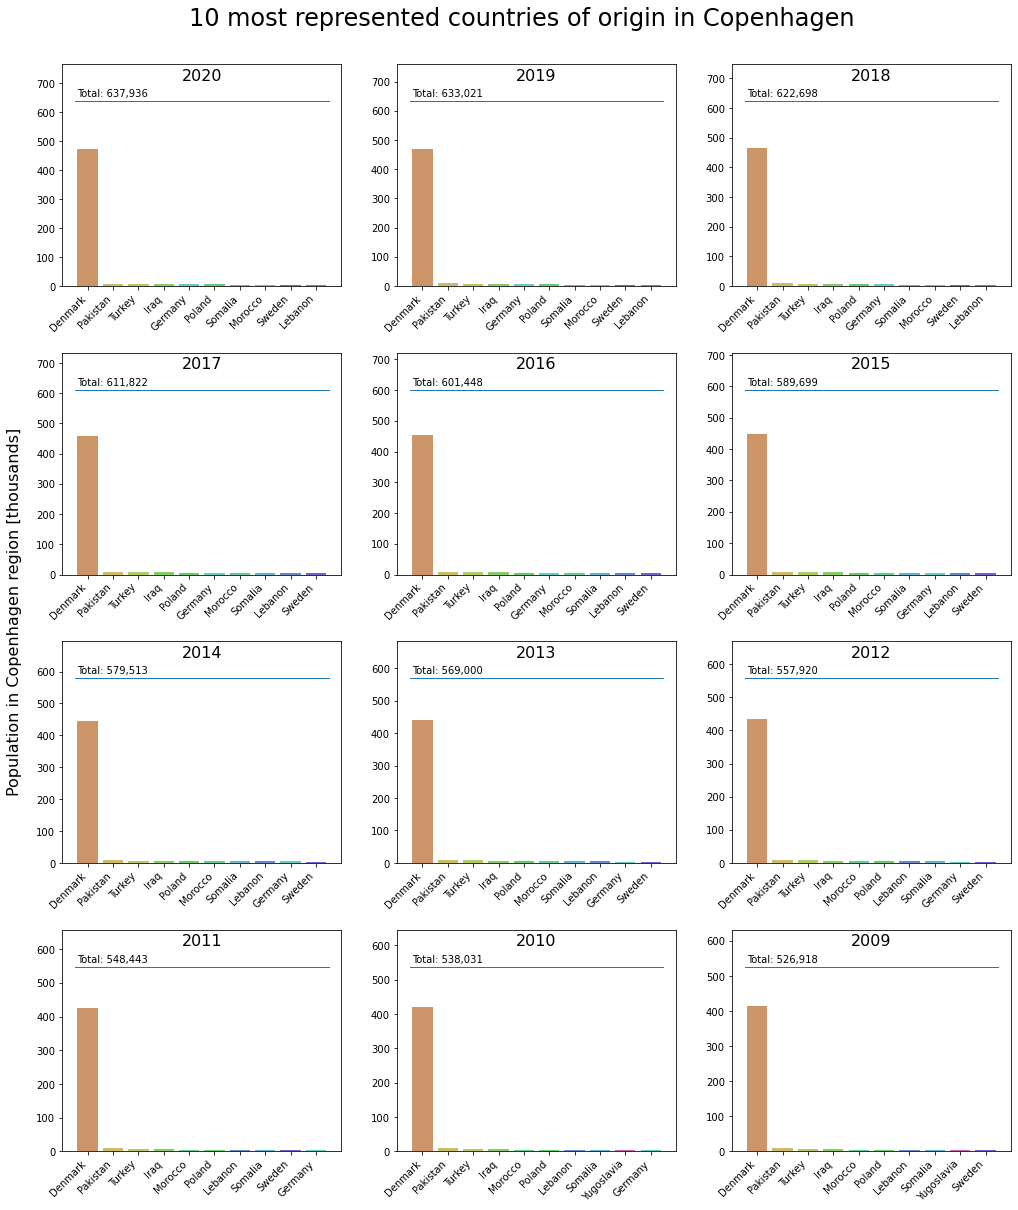

In [19]:
# Get the number of years.
n_years = len(years)

# Get the number of counries.
n_countries = len(countries_sorted_by_number_of_people)

# Get the number of plots.
n_plots = len(years)

# Define the plot grid.
n_plot_columns = 3
n_plot_rows = int(np.ceil(n_plots / n_plot_columns))

# Create a figure for the plots.
figure, all_axes = plt.subplots(
    n_plot_rows, n_plot_columns,
    figsize=(5 * n_plot_columns + 2, 5 * n_plot_rows),
    gridspec_kw={'hspace': 0.3}
)

# Get the handles of the bottom axes'.
bottom_axes = all_axes[-1, :]

# Define colors.
n_countries_to_map = 15
color_palette = sns.color_palette("hls",
                                  n_colors=n_countries_to_map)

# Map the colors to countries.
color_mapping = {country: color
                 for country, color
                 in zip(countries_sorted_by_number_of_people[:n_countries_to_map],
                        color_palette)}

# Plot.
for idx, (year, axes) in enumerate(zip(years, all_axes.ravel()[:n_plots])):

    total = df_country_vs_year.at[year, 'Total']

    sns.barplot(
        data=(
            df_country_vs_year
            .loc[year, ~df_country_vs_year.columns.isin(['Total'])]
            .sort_values(ascending=False)
            .head(10)
            .div(1e3)
            .reset_index()
        ),
        x='Country of origin',
        y=year,
        ax=axes,
        palette=color_mapping)

    # Set the title of the plot.
    axes.set_title(year, y=0.9)
    axes.set_xlabel('')
    axes.set_ylabel('')
    axes.set_ylim([axes.get_ylim()[0], total / 1e3 * 1.2])
    
    draw_threshold(total * 1e-3, axes, title=f'Total: {total:,.0f}')

    # Rotate x tick labels.
    plt.setp(
        axes.get_xticklabels(),
        rotation=45,
        ha='right',
        va='top',
    )

    # Apply the standard formatting.
    format_axes_annotation(axes)

# Annotate the figure.
# figure_x_label(figure, 'Day of week', y_position=0.06)
figure_y_label(figure, 'Population in Copenhagen region [thousands]', x_position=0.08)
figure.suptitle('10 most represented countries of origin in Copenhagen', 
                size=24,
                y=0.92)

##### ... by percentage 

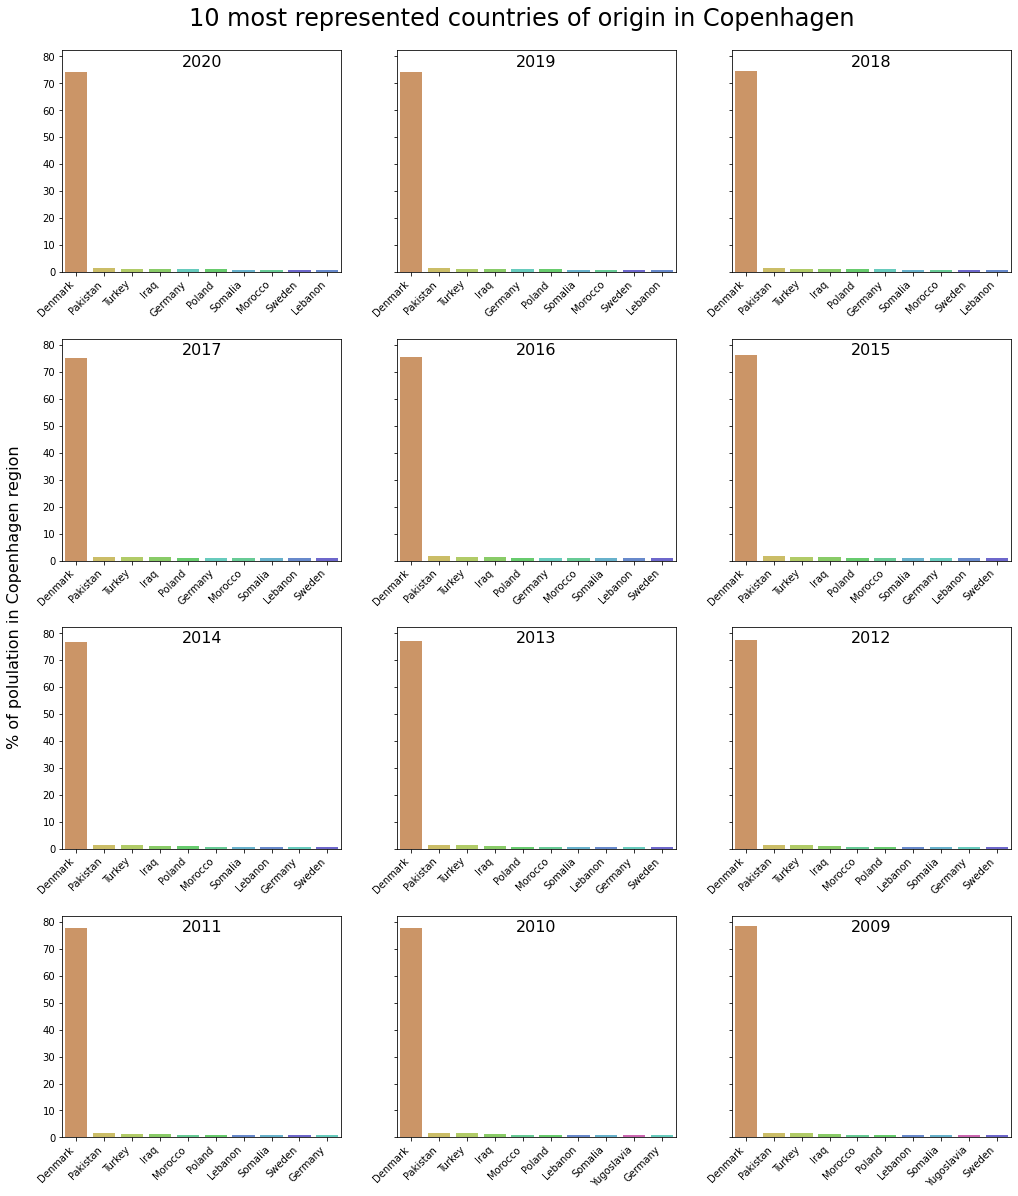

In [20]:
# Get the number of counries.
n_countries = len(countries_sorted_by_number_of_people)

# Get the number of plots.
n_plots = len(years)

# Define the plot grid.
n_plot_columns = 3
n_plot_rows = int(np.ceil(n_plots / n_plot_columns))

# Create a figure for the plots.
figure, all_axes = plt.subplots(
    n_plot_rows, n_plot_columns,
    sharey='all',
    figsize=(5 * n_plot_columns + 2, 5 * n_plot_rows),
    gridspec_kw={'hspace': 0.3}
)

# Get the handles of the bottom axes'.
bottom_axes = all_axes[-1, :]

# Define colors.
n_countries_to_map = 15
color_palette = sns.color_palette("hls",
                                  n_colors=n_countries_to_map)

# Map the colors to countries.
color_mapping = {country: color
                 for country, color
                 in zip(countries_sorted_by_number_of_people[:n_countries_to_map],
                        color_palette)}

# Plot.
for idx, (year, axes) in enumerate(zip(years, all_axes.ravel()[:n_plots])):
    
    # The total number of people in Copenhagen.
    total = df_country_vs_year.at[year, 'Total']
    
    # Show the barplot.
    sns.barplot(
        data=(
            df_country_vs_year
            .loc[year, ~df_country_vs_year.columns.isin(['Total'])]
            .sort_values(ascending=False)
            .head(10)
            .mul(100 / total)
            .reset_index()
        ),
        x='Country of origin',
        y=year,
        ax=axes,
        palette=color_mapping)

    # Set the title of the plot.
    axes.set_title(year, y=0.9)
    axes.set_xlabel('')
    axes.set_ylabel('')

    # Rotate x tick labels.
    plt.setp(
        axes.get_xticklabels(),
        rotation=45,
        ha='right',
        va='top',
    )

    # Apply the standard formatting.
    format_axes_annotation(axes)

# Annotate the figure.
# figure_x_label(figure, 'Day of week', y_position=0.06)
figure_y_label(figure, r'% of polulation in Copenhagen region', x_position=0.08)
figure.suptitle('10 most represented countries of origin in Copenhagen', 
                size=24,
                y=0.91)

##### Danes vs non-danes 

In [21]:
# Get the number of counries.
n_countries = len(countries_sorted_by_number_of_people)

# Get the number of plots.
n_plots = len(years)

# Define the plot grid.
n_plot_columns = 3
n_plot_rows = int(np.ceil(n_plots / n_plot_columns))

# Create a dataframe with data for danes vs non-danes.
df_danes_vs_non_danes = (
    df_country_vs_year
    .loc[:, 'Denmark']
    .to_frame('Danes')
)

df_danes_vs_non_danes['Non-danes'] = (
    df_country_vs_year
    .loc[:, ~df_country_vs_year.columns.isin(['Total', 'Denmark'])]
    .sum(axis=1)
    .to_frame('Non-danes')
)

df_danes_vs_non_danes[['Pct danes', 'Pct non-danes']] = (
    df_danes_vs_non_danes[['Danes', 'Non-danes']]
    .div(df_danes_vs_non_danes.sum(axis=1), axis=0)
    .mul(100)
)

# Show the dataframe
display(df_danes_vs_non_danes)

,Danes,Non-danes,Pct danes,Pct non-danes
Year,,,,
2009,413053,113865,78.39,21.61
2010,418837,119194,77.85,22.15
2011,426377,122066,77.74,22.26
2012,433433,124487,77.69,22.31
2013,439824,129176,77.30,22.70
2014,444817,134696,76.76,23.24
2015,449463,140236,76.22,23.78
2016,454826,146622,75.62,24.38
2017,460071,151751,75.20,24.80


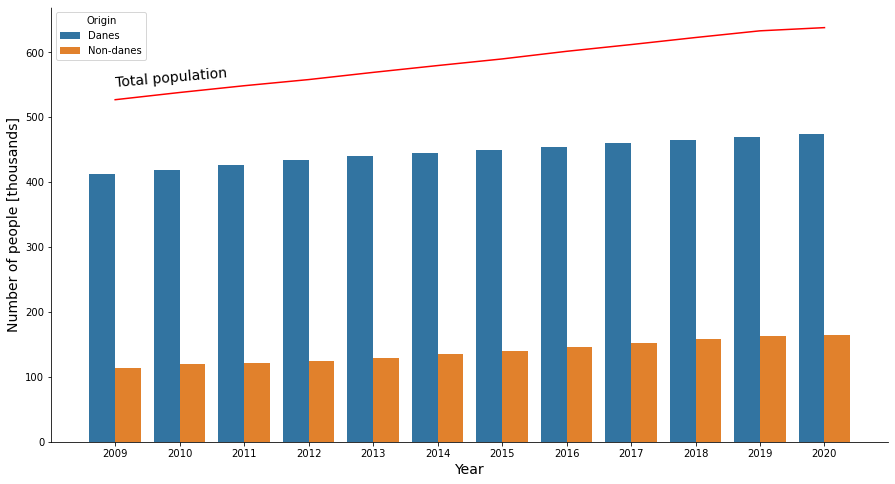

In [22]:
# Create a figure for the plots.
figure, axes = plt.subplots(figsize=(15, 8))

# Create the barplot for each year.
sns.barplot(data=(df_danes_vs_non_danes[['Danes', 'Non-danes']]
                  .div(1e3)
                  .reset_index()
                  .melt(id_vars='Year',
                        var_name='Origin',
                        value_name='Number of people')),
            x='Year',
            y='Number of people',
            hue='Origin',
            ax=axes)

# Total population over the years.
total = (
    df_danes_vs_non_danes[['Danes', 'Non-danes']]
    .div(1e3)
    .sum(axis=1)
    .to_numpy()
)

axes.plot(df_danes_vs_non_danes[['Danes', 'Non-danes']].div(1e3).sum(axis=1).to_numpy(),
          color='red')

axes.set_ylabel('Number of people [thousands]')
axes.text(0, total[0] + 20, 'Total population', rotation = 5, size=14)

format_axes(axes)
format_axes_annotation(axes)

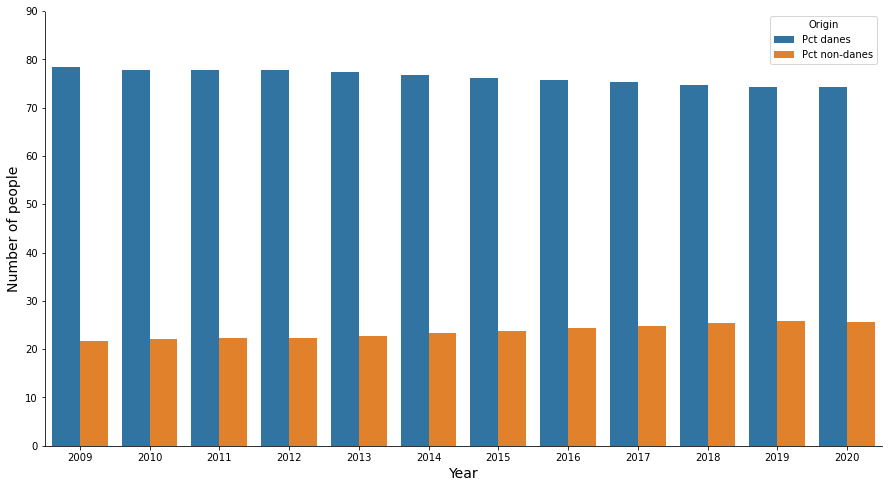

In [23]:
# Create a figure for the plots.
figure, axes = plt.subplots(figsize=(15, 8))

# Create the barplot for each year.
sns.barplot(data=(df_danes_vs_non_danes[['Pct danes', 'Pct non-danes']]
                  .reset_index()
                  .melt(id_vars='Year',
                        var_name='Origin',
                        value_name='Number of people')),
            x='Year',
            y='Number of people',
            hue='Origin',
            ax=axes)

axes.set_ylim((0, 90))

format_axes(axes)
format_axes_annotation(axes)

<hr style="border:2px solid black"> </hr>

# Citizenship

## Source

https://kk.statistikbank.dk/KKBEF8


## Load data

In [24]:
# Get file paths to all the paths.
paths_csv = [path_csv
             for path_csv in path_data_citizenship_root.glob('**/*.csv')
             if path_csv.is_file()]

# Load the dataframe from files.
df_citizenship_raw = load_split_dataframe(paths_csv)

# Show the dataframe
display(df_citizenship_raw)

,citizenship,age,sex,district,1980Q1,1981Q1,1982Q1,1983Q1,1984Q1,1985Q1,...,2011Q4,2012Q4,2013Q4,2014Q4,2015Q4,2016Q4,2017Q4,2018Q4,2019Q4,2020Q4
0,Denmark,0-4 years,Men,Copenhagen total,9146,8814,8733,8723,8700,8526,...,17408,17641,17650,17523,17236,17549,17842,17992,18148,18158
1,Denmark,0-4 years,Men,District - Indre By,817,788,798,778,729,728,...,1325,1354,1342,1337,1337,1353,1316,1311,1300,1262
2,Denmark,0-4 years,Men,District - Østerbro,1245,1246,1244,1232,1196,1128,...,2342,2332,2336,2290,2186,2145,2171,2161,2193,2154
3,Denmark,0-4 years,Men,District - Nørrebro,1266,1216,1216,1193,1183,1241,...,2310,2307,2339,2384,2354,2467,2533,2604,2536,2501
4,Denmark,0-4 years,Men,District - Vesterbro/Kongens Enghave,990,939,929,920,935,842,...,2153,2142,2135,2106,2093,2176,2213,2268,2343,2368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,Non-western countries,95+years,Women,Polling area - 9. Syd,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7676,Non-western countries,95+years,Women,Polling area - 9. Øst,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7677,Non-western countries,95+years,Women,Polling area - 9. Vest,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
7678,Non-western countries,95+years,Women,Polling area - 9. Midt,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Clean data

In [25]:
# Add district type and clean the district and time data.
df_citizenship = clean_cph_dataframe(df_citizenship_raw)

# Set the name of the dataframe.
df_citizenship.name = 'Citizenship'

# Show the dataframe.
display(df_citizenship)

,Citizenship,Age,Sex,District,District type,Value,Year,Quarter
0,Denmark,0-4 years,Men,Copenhagen total,Entire Copenhagen,9146,1980,1
1,Denmark,0-4 years,Men,Indre By,District,817,1980,1
2,Denmark,0-4 years,Men,Østerbro,District,1245,1980,1
3,Denmark,0-4 years,Men,Nørrebro,District,1266,1980,1
4,Denmark,0-4 years,Men,Vesterbro/Kongens Enghave,District,990,1980,1
...,...,...,...,...,...,...,...,...
314875,Non-western countries,95+years,Women,9. Syd,Polling area,0,2020,4
314876,Non-western countries,95+years,Women,9. Øst,Polling area,0,2020,4
314877,Non-western countries,95+years,Women,9. Vest,Polling area,0,2020,4
314878,Non-western countries,95+years,Women,9. Midt,Polling area,0,2020,4


## Show statistics

In [26]:
show_stats(df_citizenship)

,Data types
Citizenship,object
Age,object
Sex,object
District,object
District type,object
Value,int64
Year,int32
Quarter,int32


,Number of missing values
Citizenship,0
Age,0
Sex,0
District,0
District type,0
Value,0
Year,0
Quarter,0


,Citizenship,Age,Sex,District,District type,Value,Year,Quarter
count,314880,314880,314880,314880,314880,"314,880.00","314,880.00","314,880.00"
unique,3,20,2,64,3,NaN,NaN,NaN
top,Western countries,60-64 years,Men,7. Syd,Polling area,NaN,NaN,NaN
freq,104960,15744,157440,4920,260760,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,200.71,"2,000.00",2.39
std,NaN,NaN,NaN,NaN,NaN,"1,031.90",11.83,1.50
min,NaN,NaN,NaN,NaN,NaN,0.00,"1,980.00",1.00
25%,NaN,NaN,NaN,NaN,NaN,3.00,"1,990.00",1.00
50%,NaN,NaN,NaN,NaN,NaN,19.00,"2,000.00",1.00
75%,NaN,NaN,NaN,NaN,NaN,141.00,"2,010.00",4.00


<hr style="border:2px solid black"> </hr>

# Marital status

## Source

https://kk.statistikbank.dk/KKBEF1


## Load data

In [27]:
# Get file paths to all the paths.
paths_csv = [path_csv
             for path_csv in path_data_marital_status_root.glob('**/*.csv')
             if path_csv.is_file()]

# Load the dataframe from files.
df_marital_status_w_district_raw = load_split_dataframe(paths_csv)

# Show the dataframe.
display(df_marital_status_w_district_raw)

,marital status,age,sex,district,1974Q1,1975Q1,1976Q1,1977Q1,1978Q1,1979Q1,...,2011Q4,2012Q4,2013Q4,2014Q4,2015Q4,2016Q4,2017Q4,2018Q4,2019Q4,2020Q4
0,Never married,0-9 years,Men,Copenhagen total,28331,26970,25418,23547,21951,21134,...,31950,32665,33453,33957,34418,35084,35499,35617,35785,35525
1,Never married,0-9 years,Men,District - Indre By,2586,2515,2375,2130,1963,1865,...,2432,2492,2494,2515,2584,2647,2623,2578,2555,2486
2,Never married,0-9 years,Men,District - Østerbro,3456,3328,3265,3099,2915,2847,...,4240,4320,4398,4405,4368,4345,4329,4303,4305,4187
3,Never married,0-9 years,Men,District - Nørrebro,4551,4293,3998,3611,3370,3220,...,4138,4107,4177,4255,4273,4428,4457,4494,4394,4281
4,Never married,0-9 years,Men,District - Vesterbro/Kongens Enghave,3267,3084,2938,2726,2546,2413,...,3533,3617,3695,3743,3855,3988,4068,4163,4305,4330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5115,Divorced,90-99 + years,Women,Polling area - 9. Syd,1,0,2,1,1,3,...,9,11,9,9,7,7,7,4,6,7
5116,Divorced,90-99 + years,Women,Polling area - 9. Øst,0,0,1,1,4,4,...,3,3,1,1,1,1,1,1,1,3
5117,Divorced,90-99 + years,Women,Polling area - 9. Vest,0,2,2,2,2,4,...,4,3,2,1,1,2,2,0,1,1
5118,Divorced,90-99 + years,Women,Polling area - 9. Midt,1,0,0,0,1,0,...,5,5,4,4,4,2,2,2,1,1


## Clean data

In [28]:
# Add district type and clean the district and time data.
df_marital_status_w_district = clean_cph_dataframe(df_marital_status_w_district_raw)

df_marital_status_w_district.name = 'Marital status w. district'

# Show the dataframe.
display(df_marital_status_w_district)

,Marital status,Age,Sex,District,District type,Value,Year,Quarter
0,Never married,0-9 years,Men,Copenhagen total,Entire Copenhagen,28331,1974,1
1,Never married,0-9 years,Men,Indre By,District,2586,1974,1
2,Never married,0-9 years,Men,Østerbro,District,3456,1974,1
3,Never married,0-9 years,Men,Nørrebro,District,4551,1974,1
4,Never married,0-9 years,Men,Vesterbro/Kongens Enghave,District,3267,1974,1
...,...,...,...,...,...,...,...,...
240635,Divorced,90-99 + years,Women,9. Syd,Polling area,7,2020,4
240636,Divorced,90-99 + years,Women,9. Øst,Polling area,3,2020,4
240637,Divorced,90-99 + years,Women,9. Vest,Polling area,1,2020,4
240638,Divorced,90-99 + years,Women,9. Midt,Polling area,1,2020,4


## Show statistics

In [29]:
show_stats(df_marital_status_w_district)

,Data types
Marital status,object
Age,object
Sex,object
District,object
District type,object
Value,int64
Year,int32
Quarter,int32


,Number of missing values
Marital status,0
Age,0
Sex,0
District,0
District type,0
Value,0
Year,0
Quarter,0


,Marital status,Age,Sex,District,District type,Value,Year,Quarter
count,240640,240640,240640,240640,240640,"240,640.00","240,640.00","240,640.00"
unique,4,10,2,64,3,NaN,NaN,NaN
top,Married / seperated,0-9 years,Men,7. Syd,Polling area,NaN,NaN,NaN
freq,60160,24064,120320,3760,199280,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,302.96,"1,997.00",2.21
std,NaN,NaN,NaN,NaN,NaN,"1,577.82",13.56,1.47
min,NaN,NaN,NaN,NaN,NaN,0.00,"1,974.00",1.00
25%,NaN,NaN,NaN,NaN,NaN,3.00,"1,985.00",1.00
50%,NaN,NaN,NaN,NaN,NaN,48.00,"1,997.00",1.00
75%,NaN,NaN,NaN,NaN,NaN,203.00,"2,009.00",4.00


<hr style="border:2px solid black"> </hr>

# Family type and children

## Source

https://kk.statistikbank.dk/KKFAM1

## Load data

In [30]:
# Get file paths to all the paths.
path_csv = path_data_root / 'cph_children_1998-2020.csv'

# Load the dataframe from files.
df_children_raw = load_cph_df(path_csv)

# Show the dataframe.
display(df_children_raw)

,number of children,family type,district,1998Q1,1999Q1,2000Q1,2001Q1,2002Q4,2003Q4,2004Q4,...,2011Q4,2012Q4,2013Q4,2014Q4,2015Q4,2016Q4,2017Q4,2018Q4,2019Q4,2020Q4
0,0 children,Married couples and registered partnership,Copenhagen total,31498,31179,30727,30441,29955,29187,28528,...,28276,28168,28472,28713,29236,29608,30018,30645,31167,31260
1,0 children,Married couples and registered partnership,District - Indre By,2970,3021,3038,3085,3208,3217,3226,...,3259,3260,3266,3313,3439,3477,3526,3558,3621,3648
2,0 children,Married couples and registered partnership,District - Østerbro,4266,4158,4053,4101,4123,4001,3959,...,3740,3774,3767,3777,3800,4015,4119,4140,4229,4226
3,0 children,Married couples and registered partnership,District - Nørrebro,3012,3022,2999,2899,2866,2793,2660,...,2399,2448,2425,2457,2475,2445,2471,2537,2603,2530
4,0 children,Married couples and registered partnership,District - Vesterbro/Kongens Enghave,2459,2510,2512,2519,2352,2302,2190,...,2360,2295,2401,2345,2439,2448,2575,2764,2932,2950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,More than 3 children,Children below 18 years not living with parents,Polling area - 9. Syd,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1596,More than 3 children,Children below 18 years not living with parents,Polling area - 9. Øst,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1597,More than 3 children,Children below 18 years not living with parents,Polling area - 9. Vest,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1598,More than 3 children,Children below 18 years not living with parents,Polling area - 9. Midt,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Clean data

In [31]:
# Add district type and clean the district and time data.
df_children = clean_cph_dataframe(df_children_raw)

# Set the name of the dataframe.
df_children.name = 'Number of children'

# Show the dataframe.
display(df_children)

,Number of children,Family type,District,District type,Value,Year,Quarter
0,0 children,Married couples and registered partnership,Copenhagen total,Entire Copenhagen,31498,1998,1
1,0 children,Married couples and registered partnership,Indre By,District,2970,1998,1
2,0 children,Married couples and registered partnership,Østerbro,District,4266,1998,1
3,0 children,Married couples and registered partnership,Nørrebro,District,3012,1998,1
4,0 children,Married couples and registered partnership,Vesterbro/Kongens Enghave,District,2459,1998,1
...,...,...,...,...,...,...,...
36795,More than 3 children,Children below 18 years not living with parents,9. Syd,Polling area,0,2020,4
36796,More than 3 children,Children below 18 years not living with parents,9. Øst,Polling area,0,2020,4
36797,More than 3 children,Children below 18 years not living with parents,9. Vest,Polling area,0,2020,4
36798,More than 3 children,Children below 18 years not living with parents,9. Midt,Polling area,0,2020,4


In [32]:
print(df_children.loc[df_children['District type'] == 'Polling area', 'District'].unique())

['1. Østerbro' '1. Øst' '1. Nord' '1. Syd' '1. Vest' '1. Nordvest'
 '2. Sundbyvester' '2. Nord' '2. Syd' '2. Øst' '2. Vest' '3. Indre By'
 '3. Nord' '3. Syd' '3. Øst' '4. Sundbyøster' '4. Nord' '4. Syd' '4. Øst'
 '5. Nørrebro' '5. Nord' '5. Nørrebrohallen' '5. Syd' '5. Øst' '5. Vest'
 '5. Nordvest' '6. Bispebjerg' '6. Vest' '6. Nord' '6. Øst' '6. Syd'
 '7. Brønshøj' '7. Nord' '7. Syd' '7. Øst' '7. Vest' '7. Nordvest'
 '7. Katrinedal' '7. Kirkebjerg' '7. Vanløse' '8. Valby' '8. Nord'
 '8. Syd' '8. Vest' '8. Sydøst' '8. Midt' '9. Vesterbro' '9. Nord'
 '9. Syd' '9. Øst' '9. Vest' '9. Midt' '9. Sydhavn']


## Show statistics

In [33]:
show_stats(df_children)

,Data types
Number of children,object
Family type,object
District,object
District type,object
Value,int64
Year,int32
Quarter,int32


,Number of missing values
Number of children,0
Family type,0
District,0
District type,0
Value,0
Year,0
Quarter,0


,Number of children,Family type,District,District type,Value,Year,Quarter
count,36800,36800,36800,36800,"36,800.00","36,800.00","36,800.00"
unique,5,5,64,3,NaN,NaN,NaN
top,2 children,Couples living in consensual union and cohabit...,7. Syd,Polling area,NaN,NaN,NaN
freq,7360,7360,575,30475,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,635.24,"2,009.00",3.43
std,NaN,NaN,NaN,NaN,"4,252.40",6.63,1.14
min,NaN,NaN,NaN,NaN,0.00,"1,998.00",1.00
25%,NaN,NaN,NaN,NaN,2.00,"2,003.00",4.00
50%,NaN,NaN,NaN,NaN,36.00,"2,009.00",4.00
75%,NaN,NaN,NaN,NaN,240.00,"2,015.00",4.00


<hr style="border:2px solid black"> </hr>

# Income

## Source

https://kk.statistikbank.dk/KKIND3

## Load data

In [34]:
# Get file paths to all the paths.
path_csv = path_data_root / 'cph_income_1987-2019.csv'

# Load the dataframe from files.
df_income_raw = load_cph_df(path_csv)

# Show the dataframe.
display(df_income_raw)

,type of income,sex,unit,district,1987,1988,1989,1990,1991,1992,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Personal income in total (ex. imputed rent and...,Men,People with the type of income (number),Copenhagen total,188310,188504,187264,186921,187656,188058,...,215608,219409,223854,228007,231567,235640,239783,244461,248801,252465
1,Personal income in total (ex. imputed rent and...,Men,People with the type of income (number),District - Indre By,17085,17064,16725,16816,16910,17039,...,19589,19984,20321,20762,20965,21440,21963,22224,22592,22649
2,Personal income in total (ex. imputed rent and...,Men,People with the type of income (number),District - Østerbro,24644,24782,24651,24753,24760,24879,...,27282,27806,28285,28700,29012,29386,30045,30728,30766,30947
3,Personal income in total (ex. imputed rent and...,Men,People with the type of income (number),District - Nørrebro,26573,26882,26779,26808,27306,27480,...,29697,30177,30799,31362,31526,31858,31854,32151,32144,31873
4,Personal income in total (ex. imputed rent and...,Men,People with the type of income (number),District - Vesterbro/Kongens Enghave,21051,21120,20877,20680,20717,20682,...,23865,24256,24328,24612,24904,25559,26619,27734,28573,29625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,Taxable income,Women,Average income for people with the type of inc...,Polling area - 9. Syd,83490,88482,94146,96065,99903,103227,...,183239,183936,187457,185678,186023,189188,192068,197798,201083,207280
776,Taxable income,Women,Average income for people with the type of inc...,Polling area - 9. Øst,85712,91902,98439,99383,100709,103827,...,210460,211596,218379,223417,230976,236391,244615,248873,251828,258548
777,Taxable income,Women,Average income for people with the type of inc...,Polling area - 9. Vest,84548,88024,91587,94417,97398,99086,...,205297,211070,215500,218412,222992,230703,234619,246464,255126,263619
778,Taxable income,Women,Average income for people with the type of inc...,Polling area - 9. Midt,67984,72484,77335,79605,83692,86903,...,158807,158666,161538,163263,166838,172815,177835,182609,187428,192149


## Clean data

In [35]:
# Add district type and clean the district and time data.
df_income = clean_cph_dataframe(df_income_raw)

# Make each unique value from the column "Type of INCOME"
# into a column
df_income = (
    df_income
    .pivot_table(values='Value',
                 index=[column for column in df_income.columns
                        if column not in ['Type of income', 'Value']],
                 columns='Type of income',
                 aggfunc='first')
    .reset_index()
)

# Delete the name of the index of columns.
df_income.columns.name = ''

# Set the name of the dataframe.
df_income.name = 'Income'

# Show the dataframe.
display(df_income)

,Sex,Unit,District,District type,Year,Personal income in total (ex. imputed rent and before deductions of interest expenses),Taxable income
0,Men,Amount of income (kr.),1. Nord,Polling area,1987,480298,377506
1,Men,Amount of income (kr.),1. Nord,Polling area,1988,474632,389145
2,Men,Amount of income (kr.),1. Nord,Polling area,1989,499924,402011
3,Men,Amount of income (kr.),1. Nord,Polling area,1990,525126,421110
4,Men,Amount of income (kr.),1. Nord,Polling area,1991,525447,426158
...,...,...,...,...,...,...,...
12865,Women,People with the type of income (number),Østerbro,District,2015,33108,31792
12866,Women,People with the type of income (number),Østerbro,District,2016,33616,32141
12867,Women,People with the type of income (number),Østerbro,District,2017,34261,32555
12868,Women,People with the type of income (number),Østerbro,District,2018,34348,32506


## Show statistics

In [36]:
show_stats(df_income)

,Data types
,
Sex,object
Unit,object
District,object
District type,object
Year,int64
Personal income in total (ex. imputed rent and before deductions of interest expenses),object
Taxable income,object


,Number of missing values
,
Sex,0
Unit,0
District,0
District type,0
Year,0
Personal income in total (ex. imputed rent and before deductions of interest expenses),0
Taxable income,0


,Sex,Unit,District,District type,Year,Personal income in total (ex. imputed rent and before deductions of interest expenses),Taxable income
count,12870,12870,12870,12870,"12,870.00","12,870.00","12,870.00"
unique,2,3,65,3,NaN,"11,889.00","11,859.00"
top,Men,Average income for people with the type of inc...,7. Katrinedal,Polling area,NaN,"3,729.00","2,983.00"
freq,6435,4290,198,10494,NaN,6.00,7.00
mean,NaN,NaN,NaN,NaN,"2,003.00",NaN,NaN
std,NaN,NaN,NaN,NaN,9.52,NaN,NaN
min,NaN,NaN,NaN,NaN,"1,987.00",NaN,NaN
25%,NaN,NaN,NaN,NaN,"1,995.00",NaN,NaN
50%,NaN,NaN,NaN,NaN,"2,003.00",NaN,NaN
75%,NaN,NaN,NaN,NaN,"2,011.00",NaN,NaN


<hr style="border:2px solid black"> </hr>

# Life span

## Source

https://kk.statistikbank.dk/KKBEF4

## Load data

In [37]:
# Get file paths to all the paths.
path_csv = path_data_root / 'cph_life_expectancy_5_years_average_2009-2020.csv'

# Load the dataframe from files.
df_life_span_raw = load_cph_df(path_csv)

# Show the dataframe.
display(df_life_span_raw)

,district,2005:2009,2006:2010,2007:2011,2008:2012,2009:2013,2010:2014,2011:2015,2012:2016,2013:2017,2014:2018,2015:2019,2016:2020
0,District - Indre By,79.40,79.50,79.80,80.20,80.60,81.10,81.70,82.10,82.50,83.10,83.20,83.10
1,District - Østerbro,78.40,78.10,78.60,78.90,79.20,79.70,80.30,80.70,80.80,81.00,81.20,81.40
2,District - Nørrebro,72.30,72.70,73.00,73.30,73.60,74.50,75.00,75.40,75.80,76.40,76.40,76.70
3,District - Vesterbro/Kongens Enghave,73.50,73.90,74.10,74.50,75.40,75.60,76.00,76.50,76.90,77.30,77.70,78.00
4,District - Valby,75.90,75.70,75.90,76.20,76.50,76.90,77.50,77.80,77.90,78.20,78.40,78.70
5,District - Vanløse,78.10,78.30,78.60,78.70,78.70,79.30,79.50,79.60,79.70,80.50,80.80,81.30
6,District - Brønshøj-Husum,75.80,76.00,76.30,76.40,76.70,77.30,77.70,78.20,78.50,78.50,78.50,78.50
7,District - Bispebjerg,74.30,74.50,74.90,75.30,75.50,75.80,76.00,76.20,76.50,77.00,77.50,77.80
8,District - Amager Øst,76.20,76.40,77.00,77.50,77.60,77.90,78.30,78.80,79.30,80.00,80.40,81.00
9,District - Amager Vest,74.80,75.30,75.80,76.20,76.30,76.70,76.90,77.30,77.70,77.90,78.20,78.70


## Clean data

In [38]:
# Add district type and clean the district and time data.
df_life_span = clean_cph_dataframe(df_life_span_raw)

# Set the name of the dataframe.
df_life_span.name = 'Life span'

# Show the dataframe.
display(df_life_span)

,District,District type,Value,Year
0,Indre By,District,79.40,2009
1,Østerbro,District,78.40,2009
2,Nørrebro,District,72.30,2009
3,Vesterbro/Kongens Enghave,District,73.50,2009
4,Valby,District,75.90,2009
5,Vanløse,District,78.10,2009
6,Brønshøj-Husum,District,75.80,2009
7,Bispebjerg,District,74.30,2009
8,Amager Øst,District,76.20,2009
9,Amager Vest,District,74.80,2009


## Show statistics

In [39]:
show_stats(df_life_span)

,Data types
District,object
District type,object
Value,float64
Year,int32


,Number of missing values
District,0
District type,0
Value,0
Year,0


,District,District type,Value,Year
count,132,132,132.00,132.00
unique,11,1,NaN,NaN
top,Valby,District,NaN,NaN
freq,12,132,NaN,NaN
mean,NaN,NaN,70.60,"2,014.50"
std,NaN,NaN,22.52,3.47
min,NaN,NaN,0.00,"2,009.00"
25%,NaN,NaN,75.68,"2,011.75"
50%,NaN,NaN,77.30,"2,014.50"
75%,NaN,NaN,78.73,"2,017.25"


<hr style="border:2px solid black"> </hr>

# Population movement data

## Source

https://kk.statistikbank.dk/KKBEF6

## Load data

In [40]:
# Get file paths to all the paths.
path_csv = path_data_root / 'cph_polulation_stats_summary_1975-2020.csv'

# Load the dataframe from files.
df_movement_raw = load_cph_df(path_csv)

# Show the dataframe.
display(df_movement_raw)

,type of movement,district,1975,1976,1977,1978,1980,1981,1982,1987,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Live births,District - Indre By,629,495,474,442,421,423,374,399,...,689,701,675,673,692,816,723,740,703,680
1,Live births,District - Østerbro,850,792,686,727,623,624,651,659,...,1141,1189,1200,1146,1194,1267,1244,1251,1303,1268
2,Live births,District - Nørrebro,1136,915,842,848,869,761,711,838,...,1293,1278,1267,1374,1487,1543,1630,1530,1519,1491
3,Live births,District - Vesterbro/Kongens Enghave,816,660,656,614,635,573,599,590,...,1197,1236,1163,1187,1234,1256,1276,1301,1420,1357
4,Live births,District - Valby,571,437,423,420,420,399,419,453,...,816,805,814,790,858,876,907,915,991,1055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,Internal migration,Polling area - 9. Syd,424,317,266,295,284,235,266,334,...,378,345,361,339,346,330,365,314,244,296
815,Internal migration,Polling area - 9. Øst,592,522,564,512,513,450,390,495,...,207,230,296,199,207,202,274,239,225,265
816,Internal migration,Polling area - 9. Vest,374,280,238,235,198,235,189,277,...,167,148,147,145,153,158,250,237,265,270
817,Internal migration,Polling area - 9. Midt,105,83,74,55,68,57,44,96,...,109,150,123,115,117,124,105,89,161,103


## Clean data

In [41]:
# Add district type and clean the district and time data.
df_movement = clean_cph_dataframe(df_movement_raw)


# Make each unique value from the column "Type of movement"
# into a column
df_movement = (
    df_movement
    .pivot_table(values='Value',
                 index=['District', 'District type', 'Year'],
                 columns='Type of movement',
                 aggfunc='first')
    .reset_index()
)


# Delete the name of the index of columns.
df_movement.columns.name = ''

# Set the name of the dataframe.
df_movement.name = 'Population movement'

# Show the dataframe.
display(df_movement)

,District,District type,Year,Deaths,Emigrated,Immigrated,Internal migration,Internal migration from other districts,Internal migration to to other districts,Internal migratrion from danish municipalities,Internal migratrion to danish municipalities,Live births,Natural increase,Netmigration,Netmigration Copenhagen,Netmigration Denmark
0,1. Nord,Polling area,1975,134,122,84,158,663,744,562,668,93,-41,-38,-81,-106
1,1. Nord,Polling area,1976,129,98,88,110,622,681,496,637,73,-56,-10,-59,-141
2,1. Nord,Polling area,1977,111,90,92,127,637,633,446,564,72,-39,2,4,-118
3,1. Nord,Polling area,1978,127,72,77,111,652,638,465,499,73,-54,5,14,-34
4,1. Nord,Polling area,1980,128,115,107,99,686,558,587,501,75,-53,-8,128,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578,Østerbro,District,2016,461,1877,2905,3788,5533,5835,5576,5467,1267,806,1028,-302,109
2579,Østerbro,District,2017,475,2006,3000,3855,5642,5918,5818,5904,1244,769,994,-276,-86
2580,Østerbro,District,2018,463,2235,3017,3709,5310,5963,4930,5726,1251,788,782,-653,-796
2581,Østerbro,District,2019,443,2277,3018,3813,5493,6120,5255,5699,1303,860,741,-627,-444


## Show statistics

In [42]:
show_stats(df_movement)

,Data types
,
District,object
District type,object
Year,int64
Deaths,int64
Emigrated,int64
Immigrated,int64
Internal migration,int64
Internal migration from other districts,int64
Internal migration to to other districts,int64


,Number of missing values
,
District,0
District type,0
Year,0
Deaths,0
Emigrated,0
Immigrated,0
Internal migration,0
Internal migration from other districts,0
Internal migration to to other districts,0


,District,District type,Year,Deaths,Emigrated,Immigrated,Internal migration,Internal migration from other districts,Internal migration to to other districts,Internal migratrion from danish municipalities,Internal migratrion to danish municipalities,Live births,Natural increase,Netmigration,Netmigration Copenhagen,Netmigration Denmark
count,2583,2583,"2,583.00","2,583.00","2,583.00","2,583.00","2,583.00","2,583.00","2,583.00","2,583.00","2,583.00","2,583.00","2,583.00","2,583.00","2,583.00","2,583.00"
unique,63,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1. Øst,Polling area,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,41,2173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,"1,999.22",200.59,300.24,364.72,680.50,"1,538.18","1,559.65","1,196.18","1,200.54",237.78,37.14,64.47,-21.47,-4.36
std,NaN,NaN,13.03,224.12,409.68,479.98,"1,005.71","1,411.59","1,451.28","1,273.95","1,247.79",259.61,196.80,200.62,338.89,249.43
min,NaN,NaN,"1,975.00",0.00,0.00,0.00,0.00,3.00,3.00,0.00,0.00,0.00,-774.00,"-3,100.00","-1,586.00","-2,116.00"
25%,NaN,NaN,"1,990.00",72.00,82.00,106.00,195.00,723.00,695.00,506.00,527.00,100.00,-49.00,8.00,-135.00,-78.00
50%,NaN,NaN,"2,000.00",121.00,160.00,205.00,297.00,"1,060.00","1,074.00",721.00,739.00,151.00,20.00,39.00,-26.00,2.00
75%,NaN,NaN,"2,010.00",213.00,292.50,373.00,501.50,"1,610.00","1,763.50","1,177.00","1,121.50",229.00,102.00,89.00,65.00,81.50


<hr style="border:2px solid black"> </hr>

# Join dataframes



<hr style="border:2px solid black"> </hr>

# Sandbox



In [43]:
df1 = pd.DataFrame({'district': ['foo', 'bar', 'baz', 'foo'],
                    'year': [1, 2, 3, 5],
                    'par1': [7, 8, 9, 10]})
df2 = pd.DataFrame({'district': ['bar', 'baz', 'foo', 'foo'],
                    'year': [1, 2, 3, 5],
                    'par1': [9, 8, 2, 7],
                    'par2': [22, 1, 9, 10]})

display(df1)
display(df2)

display(df1.merge(df2, how='outer'))


,district,year,par1
0,foo,1,7
1,bar,2,8
2,baz,3,9
3,foo,5,10


,district,year,par1,par2
0,bar,1,9,22
1,baz,2,8,1
2,foo,3,2,9
3,foo,5,7,10


,district,year,par1,par2
0,foo,1,7,NaN
1,bar,2,8,NaN
2,baz,3,9,NaN
3,foo,5,10,NaN
4,bar,1,9,22.00
5,baz,2,8,1.00
6,foo,3,2,9.00
7,foo,5,7,10.00


In [44]:
dataframes = [
    df_marital_status,
    df_country,
    df_citizenship,
    df_marital_status,
    df_children,
    df_income,
    df_life_span,
    df_movement
]

for idx, df in enumerate(dataframes):
    if idx == 0:
        df_joint = df
    else:
        df_joint = df_joint.merge(df, how='outer')
        
display(df_joint)

,Marital status,Sex,Age,Number of people,Year,Quarter,Country of origin,Value,Citizenship,District,...,Internal migration,Internal migration from other districts,Internal migration to to other districts,Internal migratrion from danish municipalities,Internal migratrion to danish municipalities,Live births,Natural increase,Netmigration,Netmigration Copenhagen,Netmigration Denmark
0,Never married,Men,0-9 years,"28,458.00",2008,1.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Married/separated,Men,0-9 years,0.00,2008,1.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Widowed,Men,0-9 years,0.00,2008,1.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Divorced,Men,0-9 years,0.00,2008,1.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Never married,Men,10-19 years,"20,614.00",2008,1.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371698,NaN,NaN,NaN,NaN,1978,NaN,NaN,NaN,NaN,Vesterbro/Kongens Enghave,...,"3,772.00","4,414.00","5,101.00","3,782.00","4,590.00",614.00,-369.00,476.00,-687.00,-808.00
1371699,NaN,NaN,NaN,NaN,1975,NaN,NaN,NaN,NaN,Østerbro,...,"3,974.00","4,637.00","4,680.00","4,600.00","5,794.00",850.00,-195.00,-89.00,-43.00,"-1,194.00"
1371700,NaN,NaN,NaN,NaN,1976,NaN,NaN,NaN,NaN,Østerbro,...,"3,297.00","4,586.00","4,693.00","4,410.00","5,906.00",792.00,-311.00,-305.00,-107.00,"-1,496.00"
1371701,NaN,NaN,NaN,NaN,1977,NaN,NaN,NaN,NaN,Østerbro,...,"3,237.00","4,210.00","4,660.00","4,092.00","5,375.00",686.00,-330.00,248.00,-450.00,"-1,283.00"


In [47]:
dataframes = [
    df_marital_status,
    df_country,
    df_citizenship,
    df_marital_status_w_district,
    df_children,
    df_income,
    df_life_span,
    df_movement
]

all_columns = list()
common_columns = list()

df_with_district = list()
df_with_age = list()
df_with_sex = list()

for idx, df in enumerate(dataframes):
    all_columns += df.columns.to_list()
    
    try:
        a = df.name
    except:
        df_error = df
        
    
    if 'District' in df.columns:
        df_with_district.append(df.name)
    
    if 'Age' in df.columns:
        df_with_age.append(df.name)
        
    if 'Sex' in df.columns:
        df_with_sex.append(df.name)
    
    if idx == 0:
        common_columns = df.columns.to_list()
    else:
        
        common_columns = [value 
                          for value in df.columns.to_list()
                          if value in common_columns]
    
# print(set(all_columns))

def print_names(list_of_df):
    for df in list_of_df:
        print(df.name)

print('\nDistrict:')
print(len(df_with_district))
print(df_with_district)
        
print('\nAge:')
print(len(df_with_age))
print(df_with_age)

print('\nSex:')
print(len(df_with_sex))
print(df_with_sex) 


# print(common_columns)



District:
6
['Citizenship', 'Marital status w. district', 'Number of children', 'Income', 'Life span', 'Population movement']

Age:
4
['Marital status', 'Country of origin', 'Citizenship', 'Marital status w. district']

Sex:
5
['Marital status', 'Country of origin', 'Citizenship', 'Marital status w. district', 'Income']
